# Trabajo Práctico 2

## 1. Implemente un perceptrón simple que aprenda la función lógica AND y la función lógica OR, de 2 y de 4 entradas. Muestre la evolución del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

### Perceptrón simple – funciones y flujo (con *bias* absorbido, versión con historial)

**Objetivo:** entrenar un perceptrón (activación signo) para aprender **AND/OR** con 2 y 4 entradas, actualizando **patrón por patrón** y registrando tanto el **ECM por época** como el **historial de pesos** (para visualizar la frontera de decisión *epoch a epoch*).

Usamos el *bias* absorbido como **una entrada constante 1**, así todos los pesos se actualizan con la misma regla.

---

### Funciones incluidas

- **`step(h)`**  
  Activa con **signo**: devuelve `+1` si $h \ge 0$ y $-1$ si $h < 0$.

- **`augment_with_bias(X)`**  
  Agrega una columna de unos: $X \mapsto \tilde{X} = [X \mid \mathbf{1}]$ (la última columna representa la entrada del *bias*).

- **`forward_aug(X_{\mathrm{aug}}, w_{\mathrm{aug}})`**  
  Calcula la salida **discreta** del perceptrón:
  $$
  O \;=\; \mathrm{sgn}\!\big(\tilde{X}\,\tilde{\mathbf{w}}\big).
  $$

- **`predict(X, w_{\mathrm{aug}})`**  
  Conveniencia: aplica `augment_with_bias` y luego `forward_aug` para predecir desde $X$ (no aumentada).

- **`mse(y, \hat{y})`**  
  **ECM** sobre salidas discretas $\{-1,+1\}$:
  $$
  \mathrm{ECM} \;=\; \frac{1}{P}\sum_{i=1}^{P}\big(y_i-\hat{y}_i\big)^2
  $$
  (equivale a $4\times$ la tasa de error cuando $y,\hat{y}\in\{-1,+1\}$).

- **`train_perceptron_aug_with_history(X, y, \eta, \text{max\_epochs}, \text{shuffle}, \text{random\_state})`**  
  Entrena **en línea** (muestra por muestra) con **vector aumentado**.  
  Inicializa $\tilde{\mathbf{w}} \sim \mathcal{N}(0, 0.01)$ y, **solo si hay error**, aplica la regla del perceptrón:
  $$
  \tilde{\mathbf{w}}\;\leftarrow\;\tilde{\mathbf{w}}+\eta\,t\,\tilde{\mathbf{x}},
  $$
  donde $t\in\{-1,+1\}$, $\tilde{\mathbf{x}}=[\mathbf{x};1]$ y la **última componente** de $\tilde{\mathbf{w}}$ es el **peso del bias**.  
  Devuelve:
  - `w_hist`: matriz $\big(E \times (N+1)\big)$ con los pesos **al final de cada época** (incluye el bias).
  - `ecms`: lista con el **ECM por época**.  
  Se detiene temprano si en una época no hay errores (separación perfecta).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def step(h: np.ndarray) -> np.ndarray:
    """Signo: +1 si h>=0, -1 si h<0."""
    return np.where(h >= 0, 1, -1)

def augment_with_bias(X: np.ndarray) -> np.ndarray:
    """Agrega una columna de 1s: X -> [X | 1]. El último peso es el bias."""
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([X, ones])

def forward_aug(X_aug: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Salida del perceptrón con X """
    return step(X_aug @ w_aug)

def predict(X: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Predice a partir de X (no aumentada)."""
    return forward_aug(augment_with_bias(X), w_aug)

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ECM sobre etiquetas en {+1,-1}."""
    y_true = np.asarray(y_true)
    return float(np.mean((y_true - y_pred) ** 2))

# -------------------------
# Entrenamiento con HISTORIAL por ÉPOCA
# -------------------------
def train_perceptron_aug_with_history(
    X: np.ndarray,
    y: np.ndarray,
    eta: float = 0.1,
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int | None = None,
):
    rng = np.random.default_rng(random_state)
    X_aug = augment_with_bias(X)
    y = np.asarray(y, dtype=int)

    w_aug = rng.normal(0, 0.01, size=X_aug.shape[1])

    w_hist = []
    ecms = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(len(X_aug))
            Xe, ye = X_aug[idx], y[idx]
        else:
            Xe, ye = X_aug, y

        mistakes = 0
        for xi, ti in zip(Xe, ye):
            if step(xi @ w_aug) != ti:
                w_aug += eta * ti * xi
                mistakes += 1

        # log de fin de época SIEMPRE
        w_hist.append(w_aug.copy())
        ecms.append(mse(y, forward_aug(X_aug, w_aug)))

        if mistakes == 0:  # early stop si separó perfecto
            break

    return np.array(w_hist), np.array(ecms)


- **`dataset_gate(gate)`**  
  Genera el dataset de la compuerta lógica elegida (**AND** u **OR**):  
  $X=\{(0,0),(0,1),(1,0),(1,1)\}$ y  
  $y=\{-1,-1,-1,+1\}$ (AND) / $y=\{-1,+1,+1,+1\}$ (OR).

- **`plot_boundary_on_ax(ax, w_{\text{aug}})`**  
  Dibuja la **frontera de decisión** del perceptrón en 2D.  
  Con $w_{\text{aug}}=[w_1,w_2,w_0]$ (siendo $w_0$ el *bias*), la recta es:
  $$
  w_1 x_1 + w_2 x_2 + w_0 = 0
  \;\;\Rightarrow\;\;
  x_2 = -\frac{w_1 x_1 + w_0}{w_2}
  $$
  (si $w_2=0$, la frontera es vertical: $x_1=-\tfrac{w_0}{w_1}$).

- **`annotate_points(ax, X, y)`**  
  Plotea los puntos de $X$ y etiqueta cada clase ($+1$ / $-1$).

- **`run_experiment_for_gate(gate, \{\eta\})`**  
  Para la compuerta elegida, recorre una lista de tasas de aprendizaje $\eta$, y para cada una:
  1) **Entrena** con `train_perceptron_aug_with_history` (ya definida antes) y obtiene  
     el **historial de pesos por época** $w_{\text{hist}}$ y el **ECM por época**.  
  2) Grafica **ECM vs. época**.  
  3) Muestra, en un **panel lateral**, la **evolución de la recta** (una subfigura por época).


In [2]:
def dataset_gate(gate: str = "AND", dim: int = 2):
    g = gate.strip().lower()
    if dim == 2:
        X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
        if g == "and":
            y = np.array([-1,-1,-1, 1], dtype=int)
        elif g == "or":
            y = np.array([-1, 1, 1, 1], dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    elif dim == 4:
        X = np.array([[int(b) for b in f"{i:04b}"] for i in range(16)], dtype=float)
        if g == "and":
            y = np.array([-1]*15 + [1], dtype=int)
        elif g == "or":
            y = np.array([-1] + [1]*15, dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    else:
        raise ValueError("dim debe ser 2 o 4")


def plot_boundary_on_ax(ax, w_aug, eps: float = 1e-12):
    """Dibuja la frontera de decisión en el eje ax dado w_aug."""
    w1, w2, wb = w_aug
    x_vals = np.linspace(-0.2, 1.2, 200)
    if abs(w2) > eps:
        y_vals = -(w1 * x_vals + wb) / w2
        ax.plot(x_vals, y_vals, linewidth=2)
    elif abs(w1) > eps:
        ax.axvline(x=-wb / w1, linewidth=2)


def annotate_points(ax, X, y):
    """Plotea puntos y etiquetas de clase."""
    X_pos = X[y == 1]; X_neg = X[y == -1]
    ax.scatter(X_pos[:,0], X_pos[:,1], label="+1")
    ax.scatter(X_neg[:,0], X_neg[:,1], label="-1")
    for pt, lab in zip(X, y):
        ax.annotate(str(int(lab)), (pt[0]+0.02, pt[1]+0.02), fontsize=9)
    ax.set_xlim(-0.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.grid(True)

def run_experiment_for_gate(
    gate: str = "AND",
    etas = (0.01, 0.05, 0.1, 0.5, 1.0),
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int = 42,
):
    """
    Para la compuerta 'gate' entrena con cada eta, grafica:
      (1) ECM vs. época y (2) evolución lateral de la frontera por época.
    Requiere train_perceptron_aug_with_history(X,y,eta,...) definido previamente.
    """
    X, y = dataset_gate(gate)
    for eta in etas:
        w_hist, ecms = train_perceptron_aug_with_history(
            X, y, eta=eta, max_epochs=max_epochs, shuffle=shuffle, random_state=random_state
        )

        xs = np.arange(1, len(ecms)+1)
        plt.figure(figsize=(5,3))
        if len(ecms) == 1:
            plt.scatter(xs, ecms, s=60)
        else:
            plt.plot(xs, ecms, marker='o')
        plt.xlabel("Época"); plt.ylabel("ECM")
        plt.title(f"ECM por época – {gate.upper()} (2) – η={eta}")
        plt.grid(True)
        plt.show()

        n_ep = len(w_hist)
        fig, axes = plt.subplots(1, n_ep, figsize=(3*n_ep, 3), sharex=True, sharey=True)
        if n_ep == 1:
            axes = [axes]

        for i, ax in enumerate(axes, start=1):
            annotate_points(ax, X, y)
            plot_boundary_on_ax(ax, w_hist[i-1])
            ax.set_title(f"época {i}")
            if i == 1:
                ax.legend(loc="upper left", frameon=True)

        fig.suptitle(f"{gate.upper()} (2) – evolución de la frontera – η={eta}", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()


Analizamos **exclusivamente la compuerta lógica AND (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*. (No se usa OR en este bloque.)


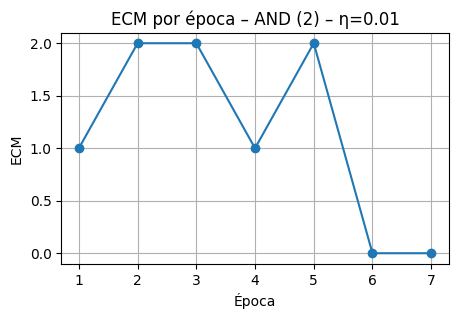

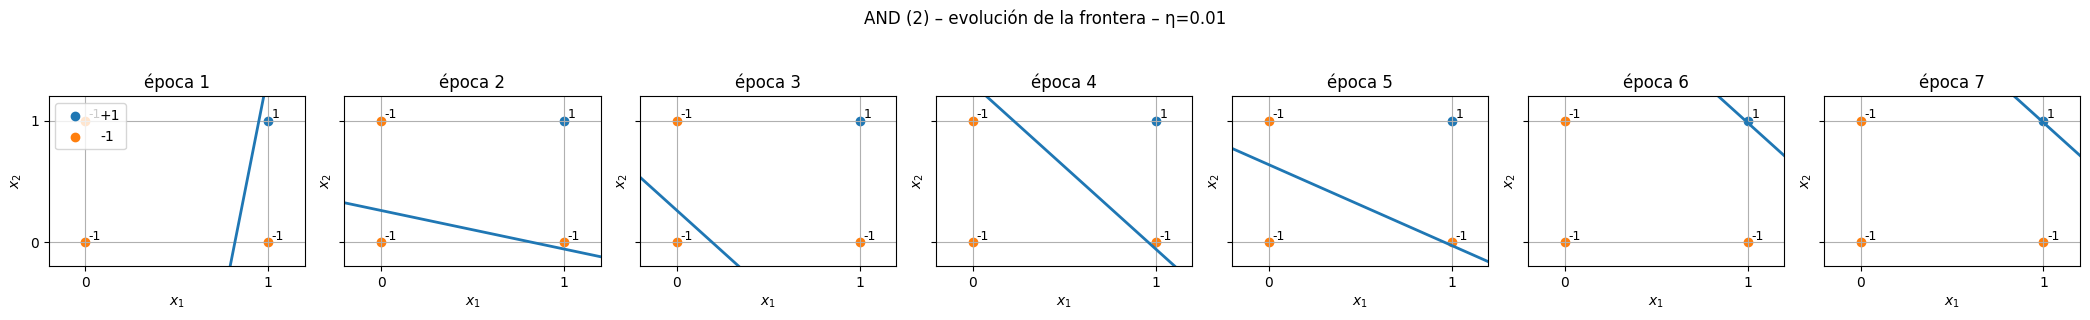

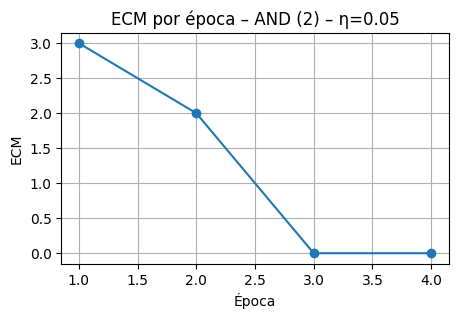

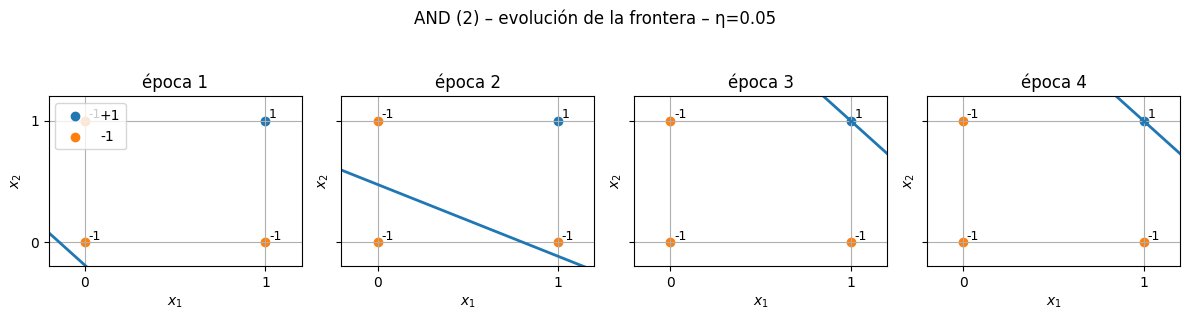

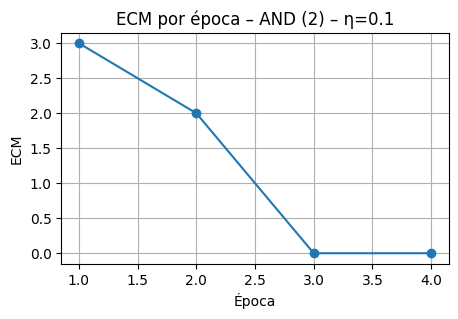

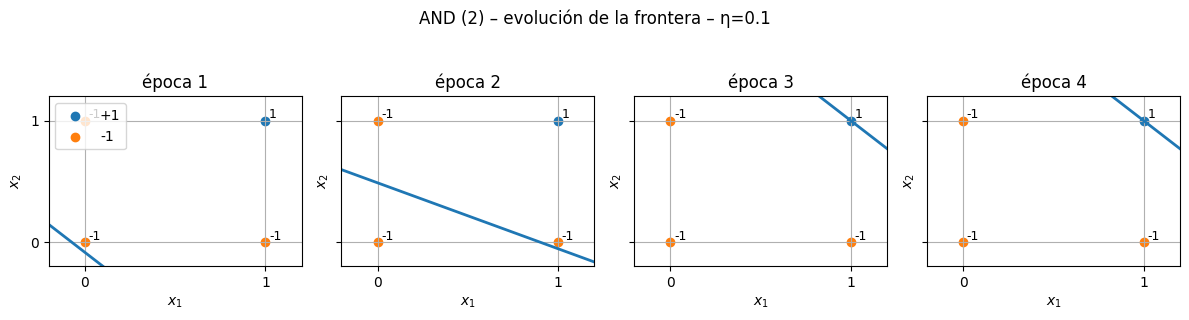

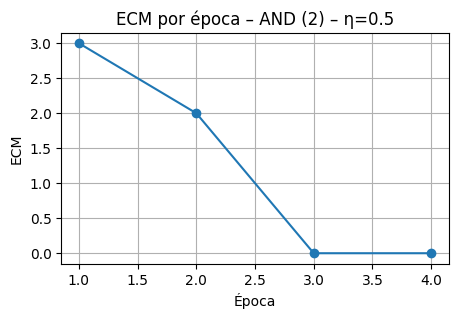

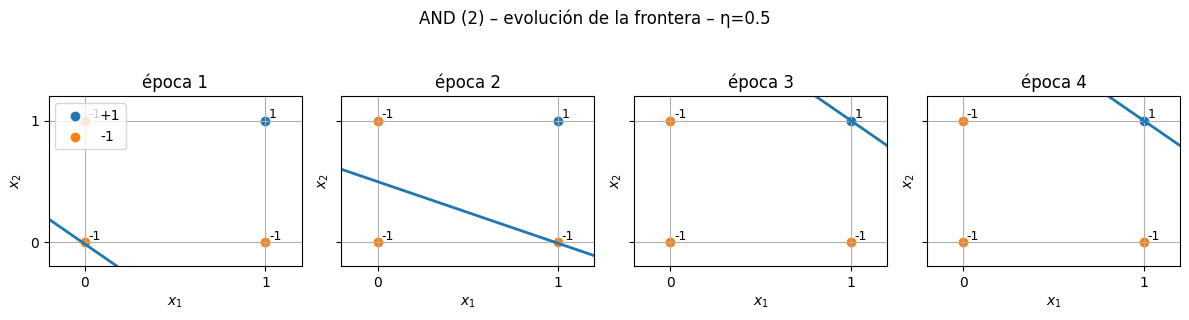

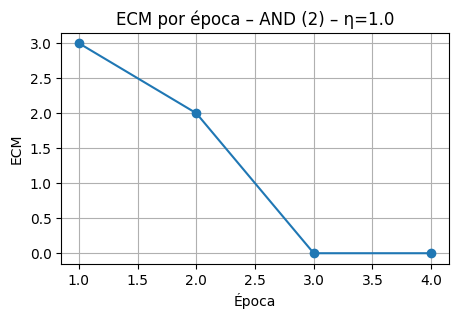

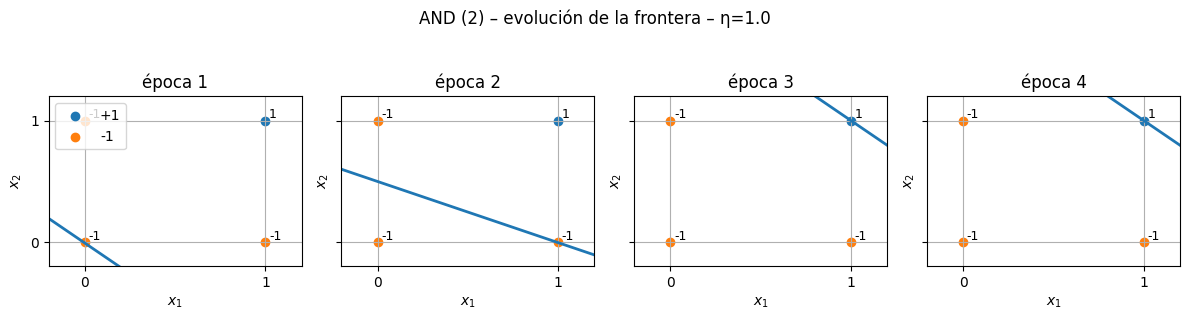

In [3]:
run_experiment_for_gate("AND", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


Analizamos **exclusivamente la compuerta lógica OR (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*.  
Datos usados: $X\in\{0,1\}^2$ y $y=\{-1,\; +1,\; +1,\; +1\}$. (No se usa AND en este bloque.)


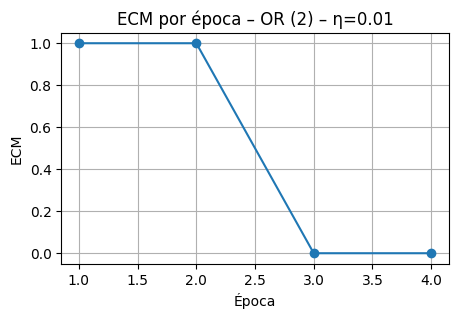

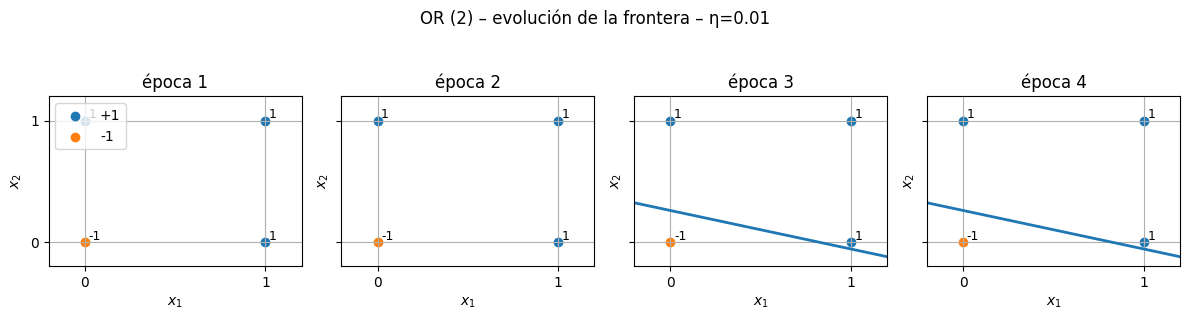

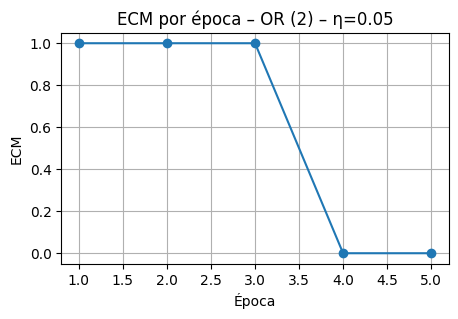

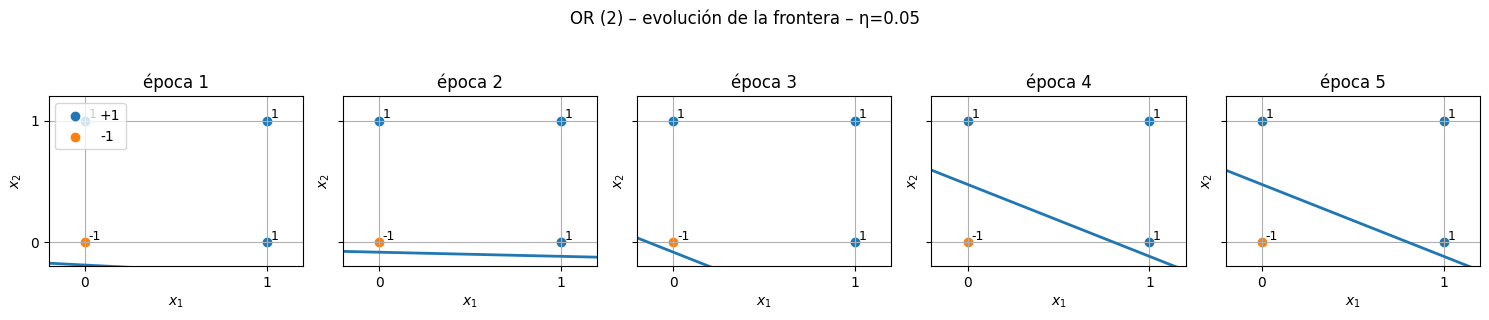

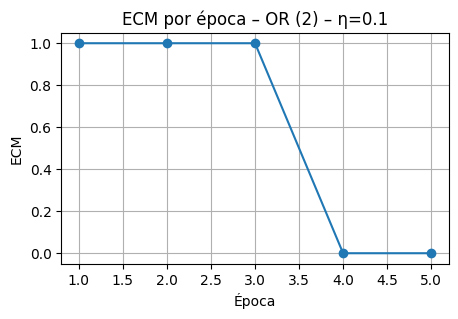

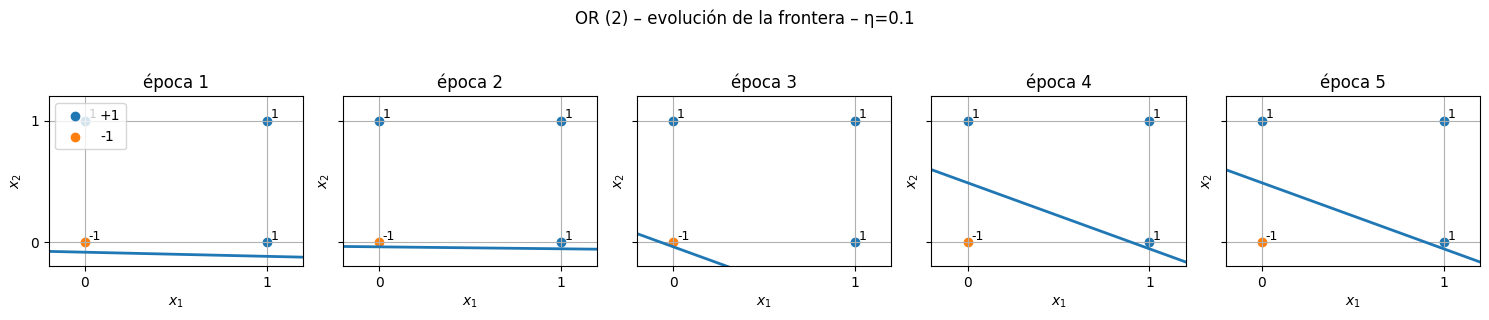

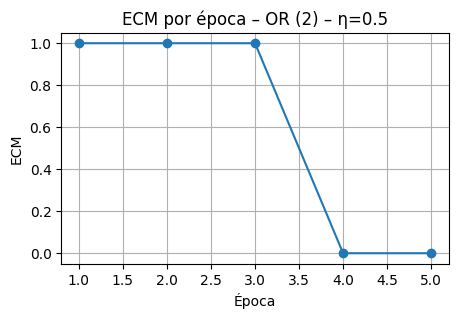

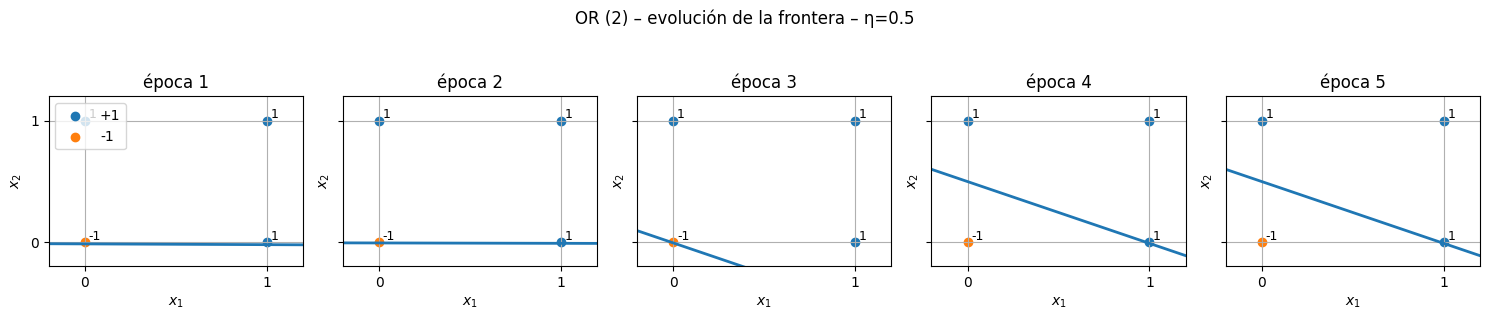

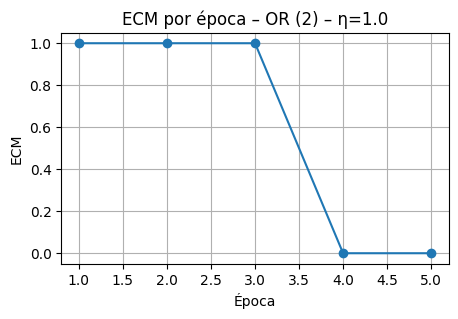

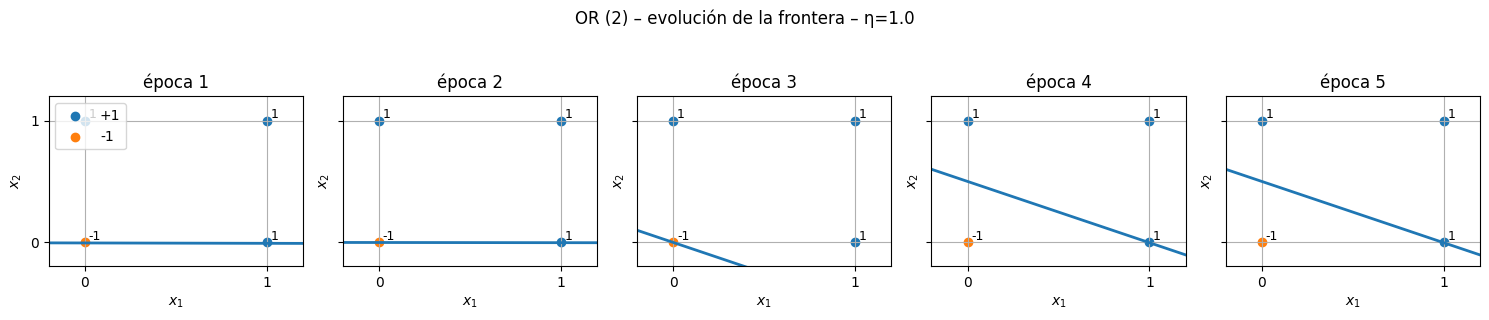

In [4]:
run_experiment_for_gate("OR", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


# 2. Determine numéricamente cómo varía la capacidad del perceptrón simple en función del número de patrones enseñados. 

## Experimento de Capacidad del Perceptrón Simple

El objetivo es estimar **cuántos patrones aleatorios puede aprender un perceptrón simple con $N$ entradas**.  
La idea central es que el perceptrón solo puede resolver problemas **linealmente separables**, es decir, aquellos donde existe un hiperplano en $\mathbb{R}^N$ que divide perfectamente a las dos clases.

---

### Metodología del experimento

1. **Generación de problemas aleatorios:**  
   - Se eligen $N$ (número de entradas) y $N_p$ (número de patrones).  
   - Cada patrón es un vector $x \in [-1,1]^N$ generado al azar.  
   - A cada patrón se le asigna una etiqueta $y \in \{-1,+1\}$ también al azar.

2. **Entrenamiento del perceptrón:**  
   - Se entrena con regla del perceptrón clásico hasta un máximo de épocas.  
   - Se considera que el problema fue **aprendido** solo si el perceptrón logra error de entrenamiento exactamente 0:
     $$
     \forall i,\;\; \hat{y}_i = y_i
     $$

3. **Estimación de la fracción aprendida:**  
   - Se repite el procedimiento muchas veces (trials independientes).  
   - Se calcula:
     $$
     \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
     $$

4. **Curvas de capacidad:**  
   - Para cada $N$, se varía $N_p$ desde 1 hasta un múltiplo de $N$ (por ejemplo, $5N$).  
   - Se grafica la fracción aprendida en función de $N_p$.  

---

### Qué vamos a medir

- Eje $x$: número de patrones $N_p$.  
- Eje $y$: fracción de problemas aprendidos (probabilidad de separabilidad lineal).  

El resultado son curvas que empiezan en 1 (pocos patrones casi siempre separables) y decaen hacia 0 (muchos patrones casi nunca separables).  
El **punto medio** ($N_p^*$) se toma como la **capacidad empírica del perceptrón**, definida como el número de patrones que puede aprender en promedio.

---

### Resultado esperado

Según la teoría clásica (Cover, 1965), la capacidad está en torno a:
$$
N_p^* \;\approx\; 2N
$$

Es decir, un perceptrón simple puede aprender, en promedio, hasta aproximadamente el **doble de patrones que la cantidad de entradas** antes de que la probabilidad de éxito caiga al 50%.


In [5]:
def _predict_from_w(X, w_aug):
    """Predicción {+1,-1} usando vector aumentado y pesos finales."""
    Xa = augment_with_bias(X)
    return np.where(Xa @ w_aug >= 0, 1, -1)

def _trial_learned_once(N: int, Np: int, eta=0.1, max_epochs=200, rng=None) -> bool:
    """
    Un problema aleatorio continuo:
      - X ~ U([-1,1]^N) de tamaño Np
      - y ∈ {-1,+1} al azar
    Entrena perceptrón; True si clasifica 100% en training.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.uniform(-1.0, 1.0, size=(Np, N))
    y = rng.choice([-1, 1], size=Np)

    # random_state distinto por trial (para inicialización)
    rs = int(rng.integers(0, 1_000_000))
    w_hist, _ = train_perceptron_aug_with_history(
        X, y, eta=eta, max_epochs=max_epochs, shuffle=False, random_state=rs
    )
    yhat = _predict_from_w(X, w_hist[-1])
    return bool(np.all(yhat == y))

def capacity_sweep(Ns, k_factor=5, trials=100, eta=0.1, max_epochs=500, seed=2025):
    """
    Para cada N y Np=1..k_factor*N, estima la fracción de problemas
    aprendidos (linealmente separables) por el perceptrón.
    Devuelve: dict N -> (Np_values, frac_learned)
    """
    rng_master = np.random.default_rng(seed)
    results = {}
    for N in Ns:
        Np_vals = np.arange(1, k_factor * N + 1)
        fracs = np.empty_like(Np_vals, dtype=float)
        for j, Np in enumerate(Np_vals):
            success = 0
            for _ in range(trials):
                rng = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
                success += _trial_learned_once(N, int(Np), eta=eta, max_epochs=max_epochs, rng=rng)
            fracs[j] = success / trials
        results[N] = (Np_vals, fracs)
    return results

def half_capacity_point(Np_vals, fracs):
    """Np* donde la fracción está más cerca de 0.5 (estimación de capacidad)."""
    idx = int(np.argmin(np.abs(fracs - 0.5)))
    return int(Np_vals[idx]), float(fracs[idx])


## Experimento ejecutado: Capacidad empírica del perceptrón simple

En este bloque de código variamos **la dimensión del perceptrón ($N$)** y el número de **trials** (repeticiones del experimento aleatorio) para estimar de manera robusta la capacidad.

---

### Configuración usada

- **Dimensiones comparadas ($N$):** $2, 4, 8, 20, 30$  
- **Cantidad de patrones probados ($N_p$):** desde 1 hasta $5 \cdot N$ (con `k_factor=5`).  
- **Tasa de aprendizaje:** $\eta = 0.1$  
- **Épocas máximas:** 500  
- **Semilla aleatoria:** 2854  
- **Número de trials:** $50$, $100$ y $500$

---

### Qué se midió

1. Para cada $N$ y cada $N_p$, se generaron problemas aleatorios con entradas continuas en $[-1,1]^N$ y salidas en $\{-1,+1\}$.  
2. Se entrenó un perceptrón simple y se contó como **aprendido** solo si alcanzó **error de entrenamiento 0**.  
3. Se repitió el procedimiento varias veces (`trials`) y se calculó la **fracción de problemas aprendidos**:
   $$
   \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
   $$
4. Se graficó la curva $\text{frac}(N_p)$ para cada $N$ y se marcó con una línea roja punteada la referencia teórica en $2N$.  

---

### Resultados esperados

- Las curvas comienzan cerca de 1 (cuando $N_p$ es chico, casi siempre son separables).  
- A medida que $N_p$ aumenta, la fracción de problemas aprendidos cae hacia 0.  
- El punto medio ($N_p^*$, donde la fracción ≈ 0.5) aparece aproximadamente en $2N$, confirmando la predicción teórica de que la capacidad del perceptrón simple es cercana al doble de la dimensión de entrada.

---



=== TRIALS = 100 ===


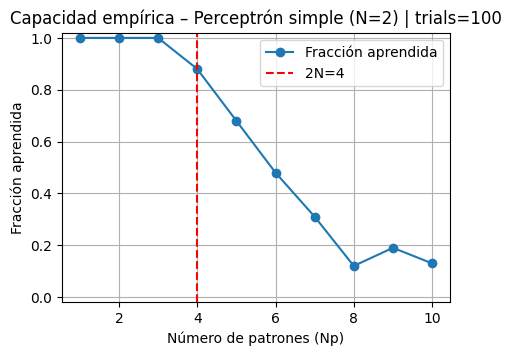

Np* (aprox. fracción≈0.5) por N:
  N=2: Np*≈6 (fracción=0.48)


In [ ]:
# Config global
#Ns         = (2, 4, 8, 20, 30)     # dimensiones a comparar
Ns = (4,)
k_factor   = 5             # Np max = k_factor * N
eta        = 0.1
max_epochs = 500
seed       = 2854
#trials_list = [10, 50, 100, 500]
trials_list = [100]

for trials in trials_list:
    print(f"\n=== TRIALS = {trials} ===")
    results = capacity_sweep(
        Ns=Ns, k_factor=k_factor, trials=trials,
        eta=eta, max_epochs=max_epochs, seed=seed
    )

    # Plots por N
    for N, (Np_vals, fracs) in results.items():
        plt.figure(figsize=(5,3.5))
        plt.plot(Np_vals, fracs, marker='o', label="Fracción aprendida")

        # --- MARCA en 2N ---
        plt.axvline(2*N, color="red", linestyle="--", label=f"2N={2*N}")

        plt.xlabel("Número de patrones (Np)")
        plt.ylabel("Fracción aprendida")
        plt.title(f"Capacidad empírica – Perceptrón simple (N={N}) | trials={trials}")
        plt.ylim(-0.02, 1.02)
        plt.grid(True)
        plt.legend()
        plt.show()

    # Resumen de Np* (fracción ≈ 0.5)
    print("Np* (aprox. fracción≈0.5) por N:")
    for N, (Np_vals, fracs) in results.items():
        Np_star, frac = half_capacity_point(Np_vals, fracs)
        print(f"  N={N}: Np*≈{Np_star} (fracción={frac:.2f})")
